整个项目的代码在我的 GitHub 上面，直接 download 后可以使用。

首先需要安装的一些 python 库：

pip install svgwrite

pip install svgpathtools

pip install wand


# 1. svg 生成 png
refer: http://docs.wand-py.org/en/0.4.4/

网上找的一些 svg 生成 png 的方式貌似很复杂，后来发现 wand 库直接读入 svg 图片后可以保存为 png.暂时还没有测试效率，但是对于小样本的话应该没什么问题。

In [1]:
from wand.image import Image
from wand.display import display

# 导入 svg 图片并存成 png 格式
input_file = 'data/airplane/1.svg'
output_file = 'data/1.png'

with Image(filename=input_file) as img:
    img.resize(224, 224)
    img.save(filename=output_file)

### 查看生成的图片

In [2]:
import PIL.Image as pimg
import numpy as np

(224, 224, 2)


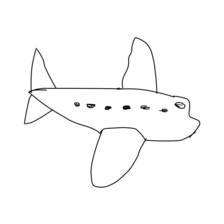

In [3]:
img = pimg.open(output_file)
# img = img.resize((224,224))
_img = np.asarray(img)
print(_img.shape)
img

这里生成的 png 是 2通道的，不过从输出来的 png 图形来看应该没有什么问题。

# 2. 解析 svg 笔画路径序列

svg 笔画路径解析比较复杂，这里只解释一下 svg_to_np 函数，至于 svg 文件夹中一些辅助函数太复杂了，其实也没有去认真研究的必要。

简单的使用例子见： https://github.com/yongyehuang/svg_parser/blob/master/example.py

In [4]:
from svg.path import parse_path

import numpy as np
from xml.dom import minidom
import time

下面贴出两个笔画的代码如下，关于 svg 代码的理解请参考 [Sketch Learning - SVG 是什么？](http://blog.csdn.net/Jerr__y/article/details/79173314)

```
<path id="0" d="M167 268 C167 268 169.3665 263.4813 172 262 C175.9896 259.7559 177.6387 259.2365 183 259 C210.4512 257.7889 216.727 256.0078 240 259 C245.7803 259.7432 247.6027 262.8186 253 268 C259.5845 274.3211 265 283 265 283 "/>
<path id="1" d="M171 264 C171 264 156.0157 299.1415 149 333 C144.9744 352.4277 146.294 356.9169 148 375 C148.4708 379.991 151.6471 385.2605 154 386 C161.2152 388.2676 172.6028 390.1283 183 386 C200.8261 378.922 205.9707 374.266 222 359 C235.7293 345.9245 235.8428 342.9286 246 326 C251.8714 316.2143 249.7558 314.4885 255 304 C260.64 292.72 268 282 268 282 "/>
```

整个函数如下，其中 original_flag 设置为 True 的话将会解析原本 svg 的点的坐标。最后每个曲线只得到一个起始点和一个终点，但是曲线中间的一些点就不考虑了，这样得到的结果其实是不够准确的。

比如  ```C167 268 169.3665 263.4813 172 262```  曲线，解析出来就只有一个终点（172 262）

所以我们需要对曲线中间的一些点进行采样，此时，通过 sample_len 来进行控制采样频率。

另外，不同数据集中解析出来的序列长度可能会相差较大，如果我们要用同一个模型进行学习的话，最好控制样本序列长度分布大概一致，这样就可以通过采样来控制了。

sample_len 是控制采样的参数，sample_len=20 表示每 20 个原始坐标采一个点。 **sample_len 设置越大，那么最后得到的序列就会越短。**

In [5]:
def svg_to_np(svg_file_name, sample_len=20, original_flag=False):
    """Parse the svg file to coordinate sequence.
    Args:
        svg_file_name: The path of the svg file.
        sample_len: dot sample parameter, the larger sample_len is, the less dot will get. Only works when original_flag is Fasle.
        original_flag: If True, get the original coordinates. If False, get the sampled coordinates.
    Returns:
        image_coord: numpy.ndarray with shape [n_dot, 3], coordinate sequence. Each line denotes the location for a dot [x, y, is_end]
        if is_end == 1, the dot is the end of a stroke.
    """
    xml_file = minidom.parse(svg_file_name)
    paths = xml_file.getElementsByTagName("path")
    xcoords = []
    ycoords = []
    pcoords = []
    for path_idx, path_element in enumerate(paths):
        mypath = parse_path(path_element.attributes["d"].value)
        # len(mypath)...number of offsets/segments
        try:
            mypath_len = int(mypath.length())  # strokeLen...natural length of the whole stroke
        except ZeroDivisionError:
            mypath_len = 0
        if original_flag | (mypath_len < sample_len):
            xcoords.append(mypath[0].start.real)
            ycoords.append(mypath[0].start.imag)
            pcoords.append(0.0)
            for offset_idx in range(len(mypath)):
                xcoords.append(mypath[offset_idx].end.real)
                ycoords.append(mypath[offset_idx].end.imag)
                pcoords.append(0.0)
            pcoords[-1] = 1.0
        else:
            # Divide a stroke into max_iter dots.
            # The larger sample_len is, the less dot will get.
            max_iter = mypath_len / sample_len
            x = 0.0
            for i in range(int(max_iter)):
                xcoords.append(mypath.point(x).real)
                ycoords.append(mypath.point(x).imag)
                pcoords.append(0.0)
                x = np.float32(x + (1 / max_iter))
            xcoords.append(mypath.point(1.0).real)
            ycoords.append(mypath.point(1.0).imag)
            pcoords.append(1.0)
    image_coord = np.column_stack((np.asarray(xcoords), np.asarray(ycoords), np.asarray(pcoords)))
    return image_coord

In [6]:
# 不做采样
tic = time.time()
svg_file = 'data/airplane/1.svg'
image_coord = svg_to_np(svg_file, original_flag=True)
image_coord = image_coord.astype('int')
print('Time cost {}s'.format(time.time() - tic))
print(image_coord.shape)
print(image_coord[:10])

Time cost 3.101670980453491s
(145, 3)
[[167 268   0]
 [172 262   0]
 [183 259   0]
 [240 259   0]
 [253 268   0]
 [265 283   1]
 [171 264   0]
 [149 333   0]
 [148 375   0]
 [154 386   0]]


In [7]:
# 进行采样
tic = time.time()
svg_file = 'data/airplane/1.svg'
image_coord = svg_to_np(svg_file)
image_coord = image_coord.astype('int')
print('Time cost {}s'.format(time.time() - tic))
print(image_coord.shape)
print(image_coord[:10])

Time cost 3.1076252460479736s
(127, 3)
[[167 268   0]
 [183 258   0]
 [206 257   0]
 [223 257   0]
 [243 259   0]
 [265 283   1]
 [171 264   0]
 [168 271   0]
 [161 290   0]
 [153 315   0]]


先看结果，对比之前贴出的 svg 源码，你会发现，如果不进行采样，那么得到的序列中的点都是原来每个曲线的终点（除了起始点）。但是如果进行采样，解析出来的坐标位置并不是直接在 svg 的代码中出现的数值，这是因为 svg 的一些坐标指的是控制点的位置，并不是真实的点位置。关于怎么通过控制点、起始点和终点来计算出笔画中每个点的位置，我也不懂，也没有必要去弄懂，直接用已有的库来解析就好了，我们要做的就是理解一下这些库函数有哪些作用。

说实话，这份代码解析 svg 还是真慢的不行，但是现在还没有找到更好的方法，只能开满进程让他跑。

下面来每个步骤分析一下：

首先使用 minidom.parse 把 svg 文件解析，svg 文件实际上就是 XML 代码，得到一个 Document 对象。

In [8]:
xml_file = minidom.parse(svg_file)
xml_file

通过 getElementsByTagName('path') 得到每个笔画元素。

In [9]:
paths = xml_file.getElementsByTagName('path')  # 获取所有的 <path> 标签
print(len(paths))   # 笔画数目
print(type(paths[0]))

19
<class 'xml.dom.minidom.Element'>


In [10]:
path0 = paths[0]
path0

<DOM Element: path at 0x7f25838412a8>

可以获取这个笔画的数值，所有元素的形状都通过 d 属性来定义。

In [11]:
path0.attributes['d'].value

'M167 268 C167 268 169.3665 263.4813 172 262 C175.9896 259.7559 177.6387 259.2365 183 259 C210.4512 257.7889 216.727 256.0078 240 259 C245.7803 259.7432 247.6027 262.8186 253 268 C259.5845 274.3211 265 283 265 283 '

调用 svg 文件夹中的 parse_path 函数解析 d 属性的值, 得到一个  Path 对象，这一部分是最难的，我觉得没有必要去理解。

In [12]:
mypath = parse_path(path0.attributes["d"].value)
print(mypath)

Path(CubicBezier(start=(167+268j), control1=(167+268j), control2=(169.3665+263.4813j), end=(172+262j)), CubicBezier(start=(172+262j), control1=(175.9896+259.7559j), control2=(177.6387+259.2365j), end=(183+259j)), CubicBezier(start=(183+259j), control1=(210.4512+257.7889j), control2=(216.727+256.0078j), end=(240+259j)), CubicBezier(start=(240+259j), control1=(245.7803+259.7432j), control2=(247.6027+262.8186j), end=(253+268j)), CubicBezier(start=(253+268j), control1=(259.5845+274.3211j), control2=(265+283j), end=(265+283j)), closed=False)


In [13]:
# 直接使用 len() 得到这个笔画一共有 5 个曲线
print(len(mypath))

5


In [14]:
# 这里返回的是这个笔画原始的点数
mypath.length()

112.00915293195905

In [15]:
print(mypath[2])
print(mypath[2].end.real)
print(mypath[2].end.imag)

CubicBezier(start=(183+259j), control1=(210.4512+257.7889j), control2=(216.727+256.0078j), end=(240+259j))
240.0
259.0


In [16]:
# point(0.1) 表示这个笔画在 十分之一的点的位置
print(mypath.point(0))
print(mypath.point(0.000001))
print(mypath.point(0.1))
print(mypath.point(0.5))
print(mypath.point(1))

(167+268j)
(167.00000000142919+267.9999999972709j)
(174.99095586038317+260.46378507138513j)
(219.68878972497367+257.3749255814213j)
(265+283j)


### 逐个笔画进行输出
现在还有一个问题就是这些笔画的顺序解析出来是怎样的，是不是按照绘画者画图的顺序进行保存的？

In [36]:
import matplotlib.pyplot as plt

print(image_coord.shape)
print(image_coord[:3])

(127, 3)
[[167 268   0]
 [183 258   0]
 [206 257   0]]


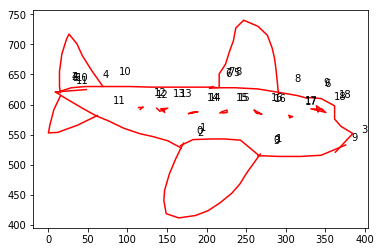

In [56]:
def plot_coord(coord):
    """绘制解析后的图。"""
    # 根据最后的一位划分笔画
    cut_ids = filter(lambda i: coord[:, -1][i] == 1, range(len(coord)))

    left = 0
    right = 0
    count = 0
    for right in cut_ids:
        x = coord[left:right+1, 0]
        y = 800 - coord[left:right+1, 1]
        plt.plot(x, y, 'r-', label=str(count))
        plt.text(x[0]+20, y[0] + 20, str(count))
        plt.text(x[-1]+20, y[-1] + 20, str(count))

        left = right + 1
        count += 1
#     plt.legend(loc='right')
    plt.show()
    
plot_coord(image_coord)

好吧，上面的图效果并不好，还是需要做个动图才行

最后贴一下这个 parse_path 函数，其实我自己也没看这个函数。。。

In [17]:
# Signature: parse_path(pathdef, current_pos=0j)
# Source:   
def parse_path(pathdef, current_pos=0j):
    # In the SVG specs, initial movetos are absolute, even if
    # specified as 'm'. This is the default behavior here as well.
    # But if you pass in a current_pos variable, the initial moveto
    # will be relative to that current_pos. This is useful.
    elements = list(_tokenize_path(pathdef))
    # Reverse for easy use of .pop()
    elements.reverse()

    segments = path.Path()
    start_pos = None
    command = None

    while elements:

        if elements[-1] in COMMANDS:
            # New command.
            last_command = command  # Used by S and T
            command = elements.pop()
            absolute = command in UPPERCASE
            command = command.upper()
        else:
            # If this element starts with numbers, it is an implicit command
            # and we don't change the command. Check that it's allowed:
            if command is None:
                raise ValueError("Unallowed implicit command in %s, position %s" % (
                    pathdef, len(pathdef.split()) - len(elements)))

        if command == 'M':
            # Moveto command.
            x = elements.pop()
            y = elements.pop()
            pos = float(x) + float(y) * 1j
            if absolute:
                current_pos = pos
            else:
                current_pos += pos

            # when M is called, reset start_pos
            # This behavior of Z is defined in svg spec:
            # http://www.w3.org/TR/SVG/paths.html#PathDataClosePathCommand
            start_pos = current_pos

            # Implicit moveto commands are treated as lineto commands.
            # So we set command to lineto here, in case there are
            # further implicit commands after this moveto.
            command = 'L'

        elif command == 'Z':
            # Close path
            segments.append(path.Line(current_pos, start_pos))
            segments.closed = True
            current_pos = start_pos
            start_pos = None
            command = None  # You can't have implicit commands after closing.

        elif command == 'L':
            x = elements.pop()
            y = elements.pop()
            pos = float(x) + float(y) * 1j
            if not absolute:
                pos += current_pos
            segments.append(path.Line(current_pos, pos))
            current_pos = pos

        elif command == 'H':
            x = elements.pop()
            pos = float(x) + current_pos.imag * 1j
            if not absolute:
                pos += current_pos.real
            segments.append(path.Line(current_pos, pos))
            current_pos = pos

        elif command == 'V':
            y = elements.pop()
            pos = current_pos.real + float(y) * 1j
            if not absolute:
                pos += current_pos.imag * 1j
            segments.append(path.Line(current_pos, pos))
            current_pos = pos

        elif command == 'C':
            control1 = float(elements.pop()) + float(elements.pop()) * 1j
            control2 = float(elements.pop()) + float(elements.pop()) * 1j
            end = float(elements.pop()) + float(elements.pop()) * 1j

            if not absolute:
                control1 += current_pos
                control2 += current_pos
                end += current_pos

            segments.append(path.CubicBezier(current_pos, control1, control2, end))
            current_pos = end

        elif command == 'S':
            # Smooth curve. First control point is the "reflection" of
            # the second control point in the previous path.

            if last_command not in 'CS':
                # If there is no previous command or if the previous command
                # was not an C, c, S or s, assume the first control point is
                # coincident with the current point.
                control1 = current_pos
            else:
                # The first control point is assumed to be the reflection of
                # the second control point on the previous command relative
                # to the current point.
                control1 = current_pos + current_pos - segments[-1].control2

            control2 = float(elements.pop()) + float(elements.pop()) * 1j
            end = float(elements.pop()) + float(elements.pop()) * 1j

            if not absolute:
                control2 += current_pos
                end += current_pos

            segments.append(path.CubicBezier(current_pos, control1, control2, end))
            current_pos = end

        elif command == 'Q':
            control = float(elements.pop()) + float(elements.pop()) * 1j
            end = float(elements.pop()) + float(elements.pop()) * 1j

            if not absolute:
                control += current_pos
                end += current_pos

            segments.append(path.QuadraticBezier(current_pos, control, end))
            current_pos = end

        elif command == 'T':
            # Smooth curve. Control point is the "reflection" of
            # the second control point in the previous path.

            if last_command not in 'QT':
                # If there is no previous command or if the previous command
                # was not an Q, q, T or t, assume the first control point is
                # coincident with the current point.
                control = current_pos
            else:
                # The control point is assumed to be the reflection of
                # the control point on the previous command relative
                # to the current point.
                control = current_pos + current_pos - segments[-1].control

            end = float(elements.pop()) + float(elements.pop()) * 1j

            if not absolute:
                end += current_pos

            segments.append(path.QuadraticBezier(current_pos, control, end))
            current_pos = end

        elif command == 'A':
            radius = float(elements.pop()) + float(elements.pop()) * 1j
            rotation = float(elements.pop())
            arc = float(elements.pop())
            sweep = float(elements.pop())
            end = float(elements.pop()) + float(elements.pop()) * 1j

            if not absolute:
                end += current_pos

            segments.append(path.Arc(current_pos, radius, rotation, arc, sweep, end))
            current_pos = end

    return segments